<a href="https://www.kaggle.com/code/rozero000/binary-food-fruit-classification?scriptVersionId=284912699" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
train_food_path = "/kaggle/input/project-data/Project Data/Food/Train"
train_fruit_path = "/kaggle/input/project-data/Project Data/Fruit/Train"
val_food_path = "/kaggle/input/project-data/Project Data/Food/Validation"
val_fruit_path = "/kaggle/input/project-data/Project Data/Fruit/Validation"

In [4]:
fruits_list = os.listdir(train_fruit_path)
foods_list = os.listdir(train_food_path)
for fruit in fruits_list:
    if fruit in foods_list:
        print(f"Warning: Conflict found: {fruit} is in both folders.")

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
def ignore_masks(path):
    return "mask" not in path.lower()

In [7]:
train_food_dataset = datasets.ImageFolder(
    root=train_food_path,
    transform=data_transforms['train'],
    target_transform=lambda y: 0
)
train_fruit_dataset = datasets.ImageFolder(
    root=train_fruit_path,
    transform=data_transforms['train'],
    target_transform=lambda y: 1,
    is_valid_file=ignore_masks
)

full_train_dataset = ConcatDataset([train_food_dataset, train_fruit_dataset])

print(f"Total Training Images: {len(full_train_dataset)}")

train_loader = DataLoader(
    dataset=full_train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

Total Training Images: 4297


In [8]:
val_food_dataset = datasets.ImageFolder(
    root=val_food_path,
    transform=data_transforms['val'],
    target_transform=lambda y: 0
)

val_fruit_dataset = datasets.ImageFolder(
    root=val_fruit_path,
    transform=data_transforms['val'],
    target_transform=lambda y: 1,
    is_valid_file=ignore_masks
)
full_val_dataset = ConcatDataset([val_food_dataset, val_fruit_dataset])

print(f"Total Validation Images: {len(full_val_dataset)}")

val_loader = DataLoader(
    full_val_dataset,
    batch_size=32,
    shuffle=False
)

Total Validation Images: 411


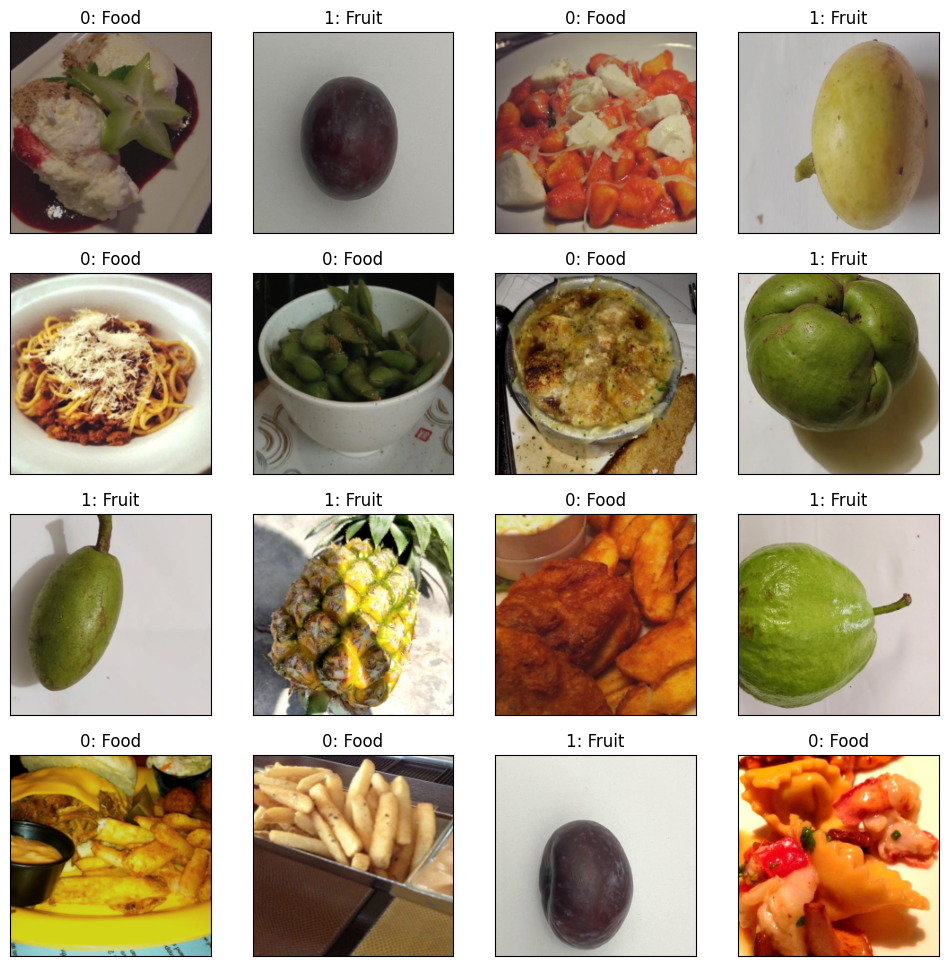

In [9]:
import numpy as np
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(norm_mean)
    std = np.array(norm_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)

data_iter = iter(train_loader)
images, labels = next(data_iter)
class_names = {0: 'Food', 1: 'Fruit'}

fig = plt.figure(figsize=(12, 12))
for i in range(min(16, len(images))):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    imshow(images[i], title=f"{labels[i].item()}: {class_names[labels[i].item()]}")
plt.show()

In [10]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

num_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 2)
)
# model.classifier[1] = nn.Linear(num_features, 2)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 63.4MB/s]


In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

criterion = nn.CrossEntropyLoss()

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    exp_lr_scheduler.step()

    train_loss = running_loss / total
    train_acc = correct / total

    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Loss: {train_loss:.4f}  "
          f"Acc: {train_acc:.4f}")


Epoch [1/10]  Loss: 0.1069  Acc: 0.9749
Epoch [2/10]  Loss: 0.0106  Acc: 0.9972
Epoch [3/10]  Loss: 0.0054  Acc: 0.9981
Epoch [4/10]  Loss: 0.0043  Acc: 0.9979
Epoch [5/10]  Loss: 0.0025  Acc: 0.9998
Epoch [6/10]  Loss: 0.0022  Acc: 0.9995
Epoch [7/10]  Loss: 0.0018  Acc: 0.9998
Epoch [8/10]  Loss: 0.0020  Acc: 0.9995
Epoch [9/10]  Loss: 0.0029  Acc: 0.9993
Epoch [10/10]  Loss: 0.0010  Acc: 1.0000


In [13]:
model.eval()
val_correct = 0
val_total = 0

with (torch.no_grad()):
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_acc = val_correct / val_total
print(f"\nValidation Accuracy: {val_acc:.4f}")


Validation Accuracy: 1.0000


In [14]:
torch.save(model.state_dict(), "model_A_food_vs_fruit.pth")
print("Model saved as model_A_food_vs_fruit.pth")

Model saved as model_A_food_vs_fruit.pth


In [15]:
from PIL import Image

def predict_image(path, model):
    model.eval()

    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

    try:
        img = Image.open(path).convert("RGB")
        img = test_transforms(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, pred = torch.max(probabilities, 1)

        label = "Food" if pred.item() == 0 else "Fruit"
        conf_percent = confidence.item() * 100
        return f"Prediction: {label} (Confidence: {conf_percent:.2f}%)"

    except Exception as e:
        return f"Error processing image {path}: {str(e)}"

In [16]:
# food
test_image_1 = "/kaggle/input/test-data/food/food.jpg"
# test_image_1 = "/kaggle/input/test-data/food/food2.jpg"
# test_image_1 = "/kaggle/input/test-data/food/food3.jpg"
# test_image_1 = "/kaggle/input/test-data/food/food4.jpg"
# test_image_1 = "/kaggle/input/test-data/food/food5.jpg"
# test_image_1 = "/kaggle/input/test-data/food/food6.avif"
# fruit
test_image_2 = "/kaggle/input/test-data/fruit/fruit.jpeg"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit2.webp"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit3.jpg"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit4.jpg"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit5.png"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit6.jpg"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit7.jpg"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit8.jpg"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit9.webp"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit10.jpeg"
# test_image_2 = "/kaggle/input/test-data/fruit/fruit13.jpeg"

print(predict_image(test_image_1, model))
print(predict_image(test_image_2, model))


Prediction: Food (Confidence: 100.00%)
Prediction: Fruit (Confidence: 99.78%)
